# 对模型进行验证
使用测试集对模型进行验证

## 变量设置

In [1]:
check_point = "schen/longformer-chinese-base-4096"

In [1]:
check_point = "/home/chenli/pre_model/best_model/Longformer_SentimentAnalysis"

## 测试集

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer

valid_dataset = load_dataset('csv',data_files='../../data/MyDataset/data2/valid_dataset.csv',split='train')
test_dataset = load_dataset('csv',data_files='../../data/MyDataset/data2/test_dataset.csv',split='train')
tokenizer = AutoTokenizer.from_pretrained(check_point)

Using custom data configuration default-062c84d526dcea84
Reusing dataset csv (/home/chenli/.cache/huggingface/datasets/csv/default-062c84d526dcea84/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
Using custom data configuration default-0f8395db45727ded
Reusing dataset csv (/home/chenli/.cache/huggingface/datasets/csv/default-0f8395db45727ded/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


In [3]:
# 分词
def preprocess_function(data):
    return tokenizer(data['text'],padding='max_length',max_length=1500,truncation=True)

In [4]:
encoded_valid_dataset = valid_dataset.map(function=preprocess_function,
                     batched=True,
                     remove_columns=['text'])
encoded_valid_dataset = encoded_valid_dataset.rename_column("label", "labels")
encoded_valid_dataset

Loading cached processed dataset at /home/chenli/.cache/huggingface/datasets/csv/default-062c84d526dcea84/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-e02ac664b17283c6.arrow


Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 344
})

In [5]:
encoded_test_dataset = test_dataset.map(function=preprocess_function,
                     batched=True,
                     remove_columns=['text'])
encoded_test_dataset = encoded_test_dataset.rename_column("label", "labels")
encoded_test_dataset

Loading cached processed dataset at /home/chenli/.cache/huggingface/datasets/csv/default-0f8395db45727ded/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-1750e6b4fb5e8b99.arrow


Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 345
})

In [6]:
import torch
from transformers.data.data_collator import DataCollatorWithPadding
batch_size = 2
valid_dataloader = torch.utils.data.DataLoader(dataset = encoded_valid_dataset,batch_size=batch_size,collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True,drop_last=True)
test_dataloader = torch.utils.data.DataLoader(dataset = encoded_test_dataset,batch_size=batch_size,collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True,drop_last=True)

## 模型加载

### Longformer + 没加入激活函数

1.模型。

In [7]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        self.linear = nn.Linear(768, 2)

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state[:,0] # 维度 [batch,seq,hidden_size]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

Using cuda device


2.加载模型参数

In [8]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer/epoch_3_valid_acc_97.1_model_weights.bin'))
model.eval()

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.8.attention.self.value_global.weight', 'bert.encoder.layer.4.attention.self.value_global.weight', 'bert.encoder.layer.3.attention.self.query_global.bias', 'bert.encoder.layer.6.attention.self.value_global.weight', 'bert.encoder.layer.10.attention.self.key_global.weight', 'bert.encoder.layer.4.attention.self.query_global.bias', 'bert.encoder.layer.4.attention.self.query_global.weight', 'bert.encoder.layer.8.attention.self.query_global.bias', 'bert.encoder.layer.8.attention.self.key_global.bias', 'bert.encoder.layer.9.attention.self.value_global.bias', 'cls.seq_relationship.bias', 'bert.encoder.layer.11.attention.self.value_global.bias', 'bert.encoder.layer.6.attention.self.query_global.bias', 'bert.encoder.layer.7.attention.self.key_global.weight', 'bert.encoder.layer.0.attention.self.key_global.weight', 'bert.encoder.layer.11.attention.self.query_gl

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

3.指标计算

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

4.验证集指标

In [12]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 97.1%

valid_acc:0.9709302325581395
confusion_matrix:[[147   7]
 [  3 187]]
general_index:{'accuracy_score': 0.9709302325581395, 'precision_score': {'precision_score_micro': 0.9709302325581395, 'precision_score_macro': 0.971958762886598, 'precision_score_weighted': 0.9711172380724047, 'precision_score_None': array([0.98      , 0.96391753])}, 'recall_score': {'recall_score_micro': 0.9709302325581395, 'recall_score_macro': 0.969377990430622, 'recall_score_weighted': 0.9709302325581395, 'recall_score_None': array([0.95454545, 0.98421053])}, 'f1_score': {'f1_score_micro': 0.9709302325581395, 'f1_score_macro': 0.9705317982456141, 'f1_score_weighted': 0.9708903891268869, 'f1_score_None': array([0.96710526, 0.97395833])}}
Done!


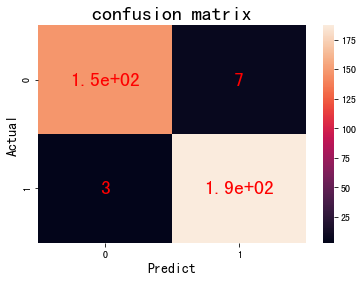

In [13]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

5.测试集指标

In [16]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 96.2%

valid_acc:0.9623188405797102
confusion_matrix:[[143  10]
 [  2 189]]
general_index:{'accuracy_score': 0.9651162790697675, 'precision_score': {'precision_score_micro': 0.9651162790697675, 'precision_score_macro': 0.9679778201351585, 'precision_score_weighted': 0.9659641430891427, 'precision_score_None': array([0.9862069 , 0.94974874])}, 'recall_score': {'recall_score_micro': 0.9651162790697675, 'recall_score_macro': 0.9620846593436676, 'recall_score_weighted': 0.9651162790697675, 'recall_score_None': array([0.93464052, 0.9895288 ])}, 'f1_score': {'f1_score_micro': 0.9651162790697675, 'f1_score_macro': 0.9644811564274651, 'f1_score_weighted': 0.9650058229580626, 'f1_score_None': array([0.95973154, 0.96923077])}}
Done!


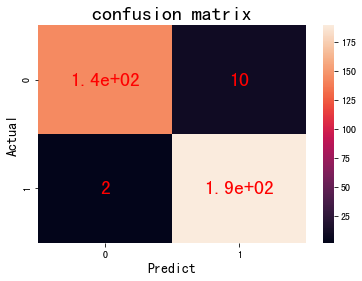

In [17]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

### Longformer + 激活函数

1.模型

In [7]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        self.linear = nn.Sequential(
            nn.Linear(768,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state[:,0] # 维度 [batch,seq,hidden_size]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

Using cuda device


Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.7.attention.self.query_global.weight', 'bert.encoder.layer.11.attention.self.value_global.bias', 'bert.encoder.layer.9.attention.self.value_global.weight', 'bert.encoder.layer.7.attention.self.key_global.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.encoder.layer.6.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.key_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.key_global.weight', 'bert.encoder.layer.9.attention.self.key_global.bias', 'bert.encoder.layer.6.attention.self.query_global.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.0.attention.self.query_global.bias', 'bert.encoder.layer.10.attention.self.query_global.weight', 'bert.encoder.layer.3.attention.self.key_gl

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

2.加载模型参数

In [8]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer/epoch_5_valid_acc_97.1_model_weights.bin'))

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.7.attention.self.query_global.weight', 'bert.encoder.layer.11.attention.self.value_global.bias', 'bert.encoder.layer.9.attention.self.value_global.weight', 'bert.encoder.layer.7.attention.self.key_global.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.encoder.layer.6.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.key_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.key_global.weight', 'bert.encoder.layer.9.attention.self.key_global.bias', 'bert.encoder.layer.6.attention.self.query_global.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.0.attention.self.query_global.bias', 'bert.encoder.layer.10.attention.self.query_global.weight', 'bert.encoder.layer.3.attention.self.key_gl

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

3.指标计算

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

4.验证集指标

In [10]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 97.1%

valid_acc:0.9709302325581395
confusion_matrix:[[147   7]
 [  3 187]]
general_index:{'accuracy_score': 0.9709302325581395, 'precision_score': {'precision_score_micro': 0.9709302325581395, 'precision_score_macro': 0.971958762886598, 'precision_score_weighted': 0.9711172380724047, 'precision_score_None': array([0.98      , 0.96391753])}, 'recall_score': {'recall_score_micro': 0.9709302325581395, 'recall_score_macro': 0.969377990430622, 'recall_score_weighted': 0.9709302325581395, 'recall_score_None': array([0.95454545, 0.98421053])}, 'f1_score': {'f1_score_micro': 0.9709302325581395, 'f1_score_macro': 0.9705317982456141, 'f1_score_weighted': 0.9708903891268869, 'f1_score_None': array([0.96710526, 0.97395833])}}
Done!


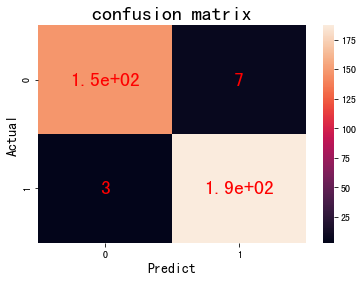

In [11]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

5.测试集指标

In [14]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.7%

valid_acc:0.9565217391304348
confusion_matrix:[[140  12]
 [  2 190]]
general_index:{'accuracy_score': 0.9593023255813954, 'precision_score': {'precision_score_micro': 0.9593023255813954, 'precision_score_macro': 0.9632547761818435, 'precision_score_weighted': 0.9606198091148781, 'precision_score_None': array([0.98591549, 0.94059406])}, 'recall_score': {'recall_score_micro': 0.9593023255813954, 'recall_score_macro': 0.9553179824561404, 'recall_score_weighted': 0.9593023255813954, 'recall_score_None': array([0.92105263, 0.98958333])}, 'f1_score': {'f1_score_micro': 0.9593023255813954, 'f1_score_macro': 0.9584239787285472, 'f1_score_weighted': 0.9591266562108257, 'f1_score_None': array([0.95238095, 0.96446701])}}
Done!


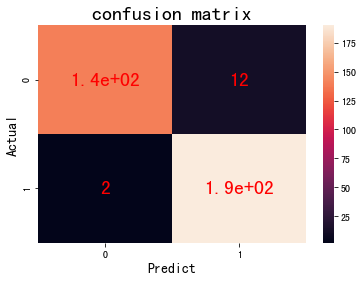

In [15]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

## Longformer-RNN模型

In [9]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.rnn = nn.RNN(input_size=768,hidden_size=512,batch_first=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = nn.Sequential(
            nn.Linear(512,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )
        

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.rnn(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

# 如果显卡的话就使用显卡
model = NeuralNetwork().to(device)
print(model)

Using cuda device


Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.0.attention.self.value_global.weight', 'bert.encoder.layer.1.attention.self.query_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.key_global.bias', 'bert.encoder.layer.9.attention.self.query_global.bias', 'bert.encoder.layer.3.attention.self.value_global.weight', 'bert.encoder.layer.1.attention.self.key_global.weight', 'bert.encoder.layer.2.attention.self.query_global.bias', 'bert.encoder.layer.7.attention.self.key_global.weight', 'bert.encoder.layer.0.attention.self.key_global.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.9.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.key_global.weight', 'cls.predictions.decoder.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'ber

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+RNN/epoch_9_valid_acc_96.2_model_weights.bin'))

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.0.attention.self.value_global.weight', 'bert.encoder.layer.1.attention.self.query_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.key_global.bias', 'bert.encoder.layer.9.attention.self.query_global.bias', 'bert.encoder.layer.3.attention.self.value_global.weight', 'bert.encoder.layer.1.attention.self.key_global.weight', 'bert.encoder.layer.2.attention.self.query_global.bias', 'bert.encoder.layer.7.attention.self.key_global.weight', 'bert.encoder.layer.0.attention.self.key_global.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.9.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.key_global.weight', 'cls.predictions.decoder.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'ber

<All keys matched successfully>

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

In [13]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.1%

valid_acc:0.9507246376811594
confusion_matrix:[[141  12]
 [  4 187]]
general_index:{'accuracy_score': 0.9534883720930233, 'precision_score': {'precision_score_micro': 0.9534883720930233, 'precision_score_macro': 0.9560561427828799, 'precision_score_weighted': 0.9542491930381658, 'precision_score_None': array([0.97241379, 0.93969849])}, 'recall_score': {'recall_score_micro': 0.9534883720930233, 'recall_score_macro': 0.9503131095370085, 'recall_score_weighted': 0.9534883720930233, 'recall_score_None': array([0.92156863, 0.97905759])}, 'f1_score': {'f1_score_micro': 0.9534883720930233, 'f1_score_macro': 0.9526415419032869, 'f1_score_weighted': 0.953341097277417, 'f1_score_None': array([0.94630872, 0.95897436])}}
Done!


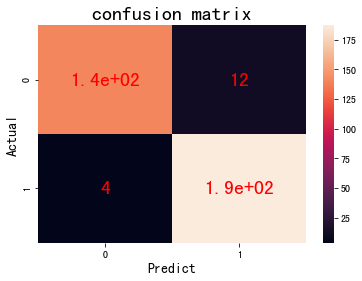

In [14]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

### Longformer-LSTM模型

In [7]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.lstm = nn.LSTM(input_size=768,hidden_size=512,batch_first=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = self.linear = nn.Sequential(
            nn.Linear(512,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.lstm(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output


Using cuda:1 device


In [8]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+LSTM/epoch_2_valid_acc_95.3_model_weights.bin'))

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.query_global.bias', 'cls.seq_relationship.weight', 'bert.encoder.layer.4.attention.self.value_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.value_global.bias', 'bert.encoder.layer.8.attention.self.value_global.weight', 'bert.encoder.layer.11.attention.self.value_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.8.attention.self.query_global.bias', 'cls.predictions.bias', 'bert.encoder.layer.10.attention.self.query_global.bias', 'bert.encoder.layer.8.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.value_global.bias', 'bert.encoder.layer

<All keys matched successfully>

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

In [10]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 95.3%

valid_acc:0.9534883720930233
confusion_matrix:[[146   8]
 [  8 182]]
general_index:{'accuracy_score': 0.9534883720930233, 'precision_score': {'precision_score_micro': 0.9534883720930233, 'precision_score_macro': 0.9529733424470266, 'precision_score_weighted': 0.9534883720930233, 'precision_score_None': array([0.94805195, 0.95789474])}, 'recall_score': {'recall_score_micro': 0.9534883720930233, 'recall_score_macro': 0.9529733424470266, 'recall_score_weighted': 0.9534883720930233, 'recall_score_None': array([0.94805195, 0.95789474])}, 'f1_score': {'f1_score_micro': 0.9534883720930233, 'f1_score_macro': 0.9529733424470266, 'f1_score_weighted': 0.9534883720930233, 'f1_score_None': array([0.94805195, 0.95789474])}}
Done!


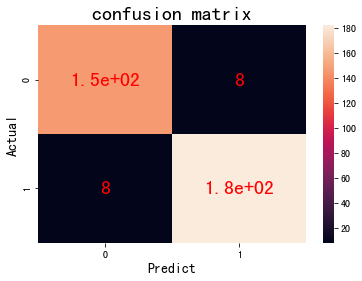

In [11]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

In [13]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.7%

valid_acc:0.9565217391304348
confusion_matrix:[[143  10]
 [  4 187]]
general_index:{'accuracy_score': 0.9593023255813954, 'precision_score': {'precision_score_micro': 0.9593023255813954, 'precision_score_macro': 0.9610138471632308, 'precision_score_weighted': 0.9597130907610357, 'precision_score_None': array([0.97278912, 0.94923858])}, 'recall_score': {'recall_score_micro': 0.9593023255813954, 'recall_score_macro': 0.9568490572494268, 'recall_score_weighted': 0.9593023255813954, 'recall_score_None': array([0.93464052, 0.97905759])}, 'f1_score': {'f1_score_micro': 0.9593023255813954, 'f1_score_macro': 0.9586254295532646, 'f1_score_weighted': 0.9592100215775593, 'f1_score_None': array([0.95333333, 0.96391753])}}
Done!


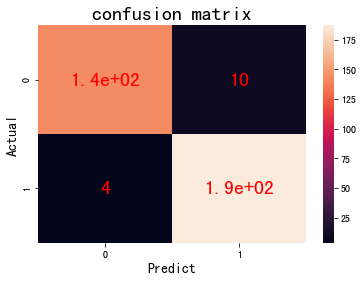

In [14]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

### Longformer+BiLSTM模型

In [7]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.lstm = nn.LSTM(input_size=768,hidden_size=512,batch_first=True,bidirectional=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = self.linear = nn.Sequential(
            nn.Linear(1024,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.lstm(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

Using cuda:1 device


In [9]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+BiLSTM/epoch_9_valid_acc_96.8_model_weights.bin'))

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.7.attention.self.value_global.bias', 'bert.encoder.layer.1.attention.self.value_global.weight', 'bert.encoder.layer.5.attention.self.key_global.bias', 'bert.encoder.layer.4.attention.self.query_global.weight', 'bert.encoder.layer.2.attention.self.query_global.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'bert.encoder.layer.0.attention.self.query_global.weight', 'bert.encoder.layer.5.attention.self.query_global.bias', 'bert.encoder.layer.10.attention.self.query_global.weight', 'cls.predictions.transform.dense.bias', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.3.attention.self.key_global.weight', 'bert.encoder.layer.5.attention.self.key_global.weight', 'bert.encoder.layer.4.attention.self.query_global.bias', 'bert.encoder.layer.9.attention.self.value_global.weight', 'cls.predictions.transform.La

<All keys matched successfully>

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

In [11]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 96.8%

valid_acc:0.9680232558139535
confusion_matrix:[[147   7]
 [  4 186]]
general_index:{'accuracy_score': 0.9680232558139535, 'precision_score': {'precision_score_micro': 0.9680232558139535, 'precision_score_macro': 0.9686202518615105, 'precision_score_weighted': 0.9681085409636044, 'precision_score_None': array([0.97350993, 0.96373057])}, 'recall_score': {'recall_score_micro': 0.9680232558139535, 'recall_score_macro': 0.9667464114832536, 'recall_score_weighted': 0.9680232558139535, 'recall_score_None': array([0.95454545, 0.97894737])}, 'f1_score': {'f1_score_micro': 0.9680232558139535, 'f1_score_macro': 0.9676068997988273, 'f1_score_weighted': 0.9679912284281745, 'f1_score_None': array([0.96393443, 0.97127937])}}
Done!


In [13]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

ValueError: Must pass 2-d input. shape=()

In [14]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.1%

valid_acc:0.9507246376811594
confusion_matrix:[[140  12]
 [  4 188]]
general_index:{'accuracy_score': 0.9534883720930233, 'precision_score': {'precision_score_micro': 0.9534883720930233, 'precision_score_macro': 0.9561111111111111, 'precision_score_weighted': 0.9542377260981911, 'precision_score_None': array([0.97222222, 0.94      ])}, 'recall_score': {'recall_score_micro': 0.9534883720930233, 'recall_score_macro': 0.9501096491228069, 'recall_score_weighted': 0.9534883720930233, 'recall_score_None': array([0.92105263, 0.97916667])}, 'f1_score': {'f1_score_micro': 0.9534883720930233, 'f1_score_macro': 0.9525648097076668, 'f1_score_weighted': 0.9533344450287972, 'f1_score_None': array([0.94594595, 0.95918367])}}
Done!


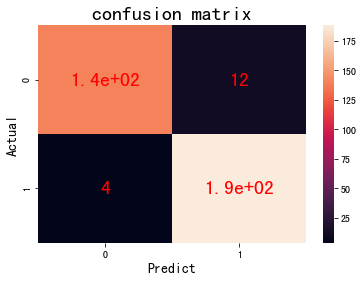

In [15]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

### Longformer+GRU模型

In [18]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.gru = nn.GRU(input_size=768,hidden_size=512,batch_first=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = nn.Sequential(
            nn.Linear(512,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )
        

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.gru(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

Using cuda:1 device


In [19]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+GRU/epoch_7_valid_acc_96.2_model_weights.bin'))

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.query_global.bias', 'cls.seq_relationship.weight', 'bert.encoder.layer.4.attention.self.value_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.value_global.bias', 'bert.encoder.layer.8.attention.self.value_global.weight', 'bert.encoder.layer.11.attention.self.value_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.8.attention.self.query_global.bias', 'cls.predictions.bias', 'bert.encoder.layer.10.attention.self.query_global.bias', 'bert.encoder.layer.8.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.value_global.bias', 'bert.encoder.layer

<All keys matched successfully>

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

In [21]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 96.2%

valid_acc:0.9622093023255814
confusion_matrix:[[147   7]
 [  6 184]]
general_index:{'accuracy_score': 0.9622093023255814, 'precision_score': {'precision_score_micro': 0.9622093023255814, 'precision_score_macro': 0.9620675495329022, 'precision_score_weighted': 0.9622018416522824, 'precision_score_None': array([0.96078431, 0.96335079])}, 'recall_score': {'recall_score_micro': 0.9622093023255814, 'recall_score_macro': 0.9614832535885167, 'recall_score_weighted': 0.9622093023255814, 'recall_score_None': array([0.95454545, 0.96842105])}, 'f1_score': {'f1_score_micro': 0.9622093023255814, 'f1_score_macro': 0.9617669941094497, 'f1_score_weighted': 0.9621973480494697, 'f1_score_None': array([0.95765472, 0.96587927])}}
Done!


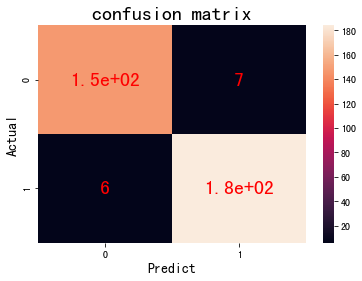

In [22]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

In [24]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.7%

valid_acc:0.9565217391304348
confusion_matrix:[[142  11]
 [  3 188]]
general_index:{'accuracy_score': 0.9593023255813954, 'precision_score': {'precision_score_micro': 0.9593023255813954, 'precision_score_macro': 0.9620169814590191, 'precision_score_weighted': 0.9601066680636542, 'precision_score_None': array([0.97931034, 0.94472362])}, 'recall_score': {'recall_score_micro': 0.9593023255813954, 'recall_score_macro': 0.9561988844403382, 'recall_score_weighted': 0.9593023255813954, 'recall_score_None': array([0.92810458, 0.98429319])}, 'f1_score': {'f1_score_micro': 0.9593023255813954, 'f1_score_macro': 0.9585613491653759, 'f1_score_weighted': 0.9591734601177397, 'f1_score_None': array([0.95302013, 0.96410256])}}
Done!


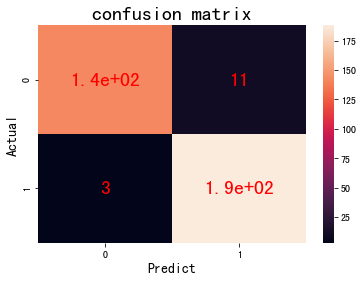

In [25]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

## Longformer+BiGRU模型

In [7]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.gru = nn.GRU(input_size=768,hidden_size=512,batch_first=True,bidirectional=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = nn.Sequential(
            nn.Linear(1024,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )
        

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.gru(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output


Using cuda:1 device


### hidden_size=768

In [8]:
import torch
from torch import nn
from transformers import AutoModel

model = "schen/longformer-chinese-base-4096"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(model)
        # 接一个BiGRU
        # self.gru = nn.GRU(input_size=768, hidden_size=512, batch_first=True, bidirectional=True, dropout=0.5)
        self.gru = nn.GRU(input_size=768, hidden_size=768, batch_first=True, bidirectional=True, dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        # self.linear = nn.Sequential(
        #     nn.Linear(1024, 512),
        #     torch.nn.Dropout(0.5),
        #     torch.nn.ReLU(),
        #     nn.Linear(512, 2)
        # )
        self.linear = nn.Sequential(
            nn.Linear(1536, 512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, input_ids, token_type_ids, attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids, token_type_ids,
                                 attention_mask).last_hidden_state  # 维度 [batch,seq,hidden_size]
        output, h_n = self.gru(output)
        output = output[:, -1, :]  # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output


## 加载参数

In [28]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+GRU/epoch_4_valid_acc_97.1_model_weights.bin'))
model.eval()

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.query_global.bias', 'cls.seq_relationship.weight', 'bert.encoder.layer.4.attention.self.value_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.value_global.bias', 'bert.encoder.layer.8.attention.self.value_global.weight', 'bert.encoder.layer.11.attention.self.value_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.8.attention.self.query_global.bias', 'cls.predictions.bias', 'bert.encoder.layer.10.attention.self.query_global.bias', 'bert.encoder.layer.8.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.value_global.bias', 'bert.encoder.layer

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [8]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+BiGRU/epoch_9_valid_acc_96.2_model_weights.bin'))
print(model)

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.5.attention.self.value_global.bias', 'bert.encoder.layer.11.attention.self.value_global.bias', 'bert.encoder.layer.3.attention.self.value_global.bias', 'bert.encoder.layer.10.attention.self.query_global.weight', 'bert.encoder.layer.3.attention.self.query_global.bias', 'bert.encoder.layer.0.attention.self.value_global.bias', 'bert.encoder.layer.4.attention.self.query_global.bias', 'cls.seq_relationship.bias', 'bert.encoder.layer.10.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.key_global.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.6.attention.self.query_global.bias', 'bert.encoder.layer.6.attention.self.key_global.weight', 'bert.encoder.layer.5.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.key_global.weight', 'bert.encoder.layer.3.attention.self.key_global.bias', 'bert.en

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [36]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/experiment_model/Longformer+GRU/epoch_4_valid_acc_96.8_model_weights.bin'))

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.query_global.bias', 'cls.seq_relationship.weight', 'bert.encoder.layer.4.attention.self.value_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.value_global.bias', 'bert.encoder.layer.8.attention.self.value_global.weight', 'bert.encoder.layer.11.attention.self.value_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.8.attention.self.query_global.bias', 'cls.predictions.bias', 'bert.encoder.layer.10.attention.self.query_global.bias', 'bert.encoder.layer.8.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.value_global.bias', 'bert.encoder.layer

<All keys matched successfully>

In [9]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('/home/chenli/pre_model/Longformer_BiGRU_hidden_size_768/epoch_9_valid_acc_97.7_model_weights.bin'))
print(model)

Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.1.attention.self.query_global.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.encoder.layer.8.attention.self.value_global.weight', 'bert.encoder.layer.5.attention.self.key_global.bias', 'bert.encoder.layer.7.attention.self.key_global.weight', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.9.attention.self.key_global.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.5.attention.self.value_global.bias', 'bert.encoder.layer.3.attention.self.value_global.bias', 'bert.encoder.layer.1.attention.self.key_global.bias', 'bert.encoder.layer.3.attention.self.query_global.bias', 'bert.encoder.layer.11.attention.self.query_global.weight', 'bert.encoder.layer.8.attention.self.query_global.weight', 'bert.encoder.layer.6.attention.self.query_global.weight', 'bert.encoder.layer.10.attention.self.value_global.

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

## 开始预测

加入混淆矩阵、精准率、召回率、F1 score

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)            
            # 添加到列表里
            y_true.append(labels.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

97.7%准确率的模型，hidden_size=768

In [11]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 97.7%

valid_acc:0.9767441860465116
confusion_matrix:[[148   6]
 [  2 188]]
general_index:{'accuracy_score': 0.9767441860465116, 'precision_score': {'precision_score_micro': 0.9767441860465116, 'precision_score_macro': 0.9778694158075601, 'precision_score_weighted': 0.9769487732757931, 'precision_score_None': array([0.98666667, 0.96907216])}, 'recall_score': {'recall_score_micro': 0.9767441860465116, 'recall_score_macro': 0.9752563226247437, 'recall_score_weighted': 0.9767441860465116, 'recall_score_None': array([0.96103896, 0.98947368])}, 'f1_score': {'f1_score_micro': 0.9767441860465116, 'f1_score_macro': 0.9764254385964912, 'f1_score_weighted': 0.9767123113015096, 'f1_score_None': array([0.97368421, 0.97916667])}}
Done!


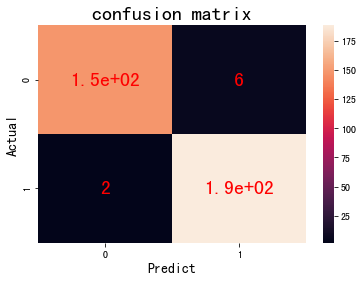

In [12]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

In [14]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.4%

valid_acc:0.9536231884057971
confusion_matrix:[[141  11]
 [  4 188]]
general_index:{'accuracy_score': 0.9563953488372093, 'precision_score': {'precision_score_micro': 0.9563953488372093, 'precision_score_macro': 0.9585687055969503, 'precision_score_weighted': 0.9569588117008457, 'precision_score_None': array([0.97241379, 0.94472362])}, 'recall_score': {'recall_score_micro': 0.9563953488372093, 'recall_score_macro': 0.9533991228070176, 'recall_score_weighted': 0.9563953488372093, 'recall_score_None': array([0.92763158, 0.97916667])}, 'f1_score': {'f1_score_micro': 0.9563953488372093, 'f1_score_macro': 0.9555658890697254, 'f1_score_weighted': 0.9562718122760947, 'f1_score_None': array([0.94949495, 0.96163683])}}
Done!


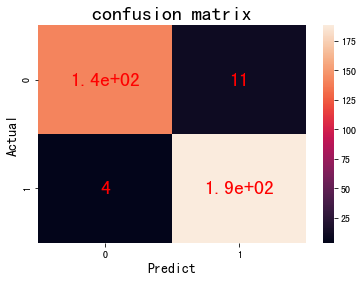

In [15]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

97.1%准确率的模型

In [30]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 97.1%

valid_acc:0.9709302325581395
confusion_matrix:[[148   6]
 [  4 186]]
general_index:{'accuracy_score': 0.9709302325581395, 'precision_score': {'precision_score_micro': 0.9709302325581395, 'precision_score_macro': 0.971217105263158, 'precision_score_weighted': 0.9709589198286412, 'precision_score_None': array([0.97368421, 0.96875   ])}, 'recall_score': {'recall_score_micro': 0.9709302325581395, 'recall_score_macro': 0.9699931647300069, 'recall_score_weighted': 0.9709302325581395, 'recall_score_None': array([0.96103896, 0.97894737])}, 'f1_score': {'f1_score_micro': 0.9709302325581395, 'f1_score_macro': 0.9705711254833522, 'f1_score_weighted': 0.9709113321857823, 'f1_score_None': array([0.96732026, 0.97382199])}}
Done!


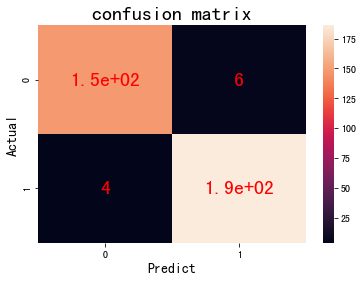

In [31]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

In [33]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.7%

valid_acc:0.9565217391304348
confusion_matrix:[[142  11]
 [  3 188]]
general_index:{'accuracy_score': 0.9593023255813954, 'precision_score': {'precision_score_micro': 0.9593023255813954, 'precision_score_macro': 0.9620169814590191, 'precision_score_weighted': 0.9601066680636542, 'precision_score_None': array([0.97931034, 0.94472362])}, 'recall_score': {'recall_score_micro': 0.9593023255813954, 'recall_score_macro': 0.9561988844403382, 'recall_score_weighted': 0.9593023255813954, 'recall_score_None': array([0.92810458, 0.98429319])}, 'f1_score': {'f1_score_micro': 0.9593023255813954, 'f1_score_macro': 0.9585613491653759, 'f1_score_weighted': 0.9591734601177397, 'f1_score_None': array([0.95302013, 0.96410256])}}
Done!


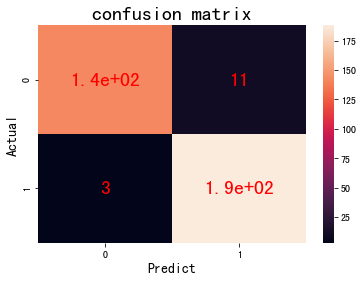

In [34]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

96.8%准确率的模型

In [38]:
valid_acc,confusion_matrix,general_index = test_loop(valid_dataloader, model, mode='Valid')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Valid Accuracy: 96.8%

valid_acc:0.9680232558139535
confusion_matrix:[[147   7]
 [  4 186]]
general_index:{'accuracy_score': 0.9680232558139535, 'precision_score': {'precision_score_micro': 0.9680232558139535, 'precision_score_macro': 0.9686202518615105, 'precision_score_weighted': 0.9681085409636044, 'precision_score_None': array([0.97350993, 0.96373057])}, 'recall_score': {'recall_score_micro': 0.9680232558139535, 'recall_score_macro': 0.9667464114832536, 'recall_score_weighted': 0.9680232558139535, 'recall_score_None': array([0.95454545, 0.97894737])}, 'f1_score': {'f1_score_micro': 0.9680232558139535, 'f1_score_macro': 0.9676068997988273, 'f1_score_weighted': 0.9679912284281745, 'f1_score_None': array([0.96393443, 0.97127937])}}
Done!


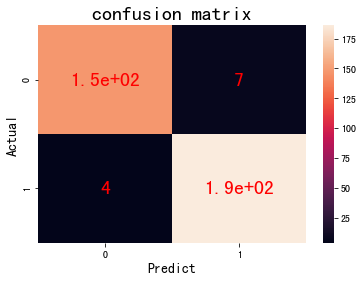

In [39]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

In [41]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.4%

valid_acc:0.9536231884057971
confusion_matrix:[[142  11]
 [  4 187]]
general_index:{'accuracy_score': 0.9563953488372093, 'precision_score': {'precision_score_micro': 0.9563953488372093, 'precision_score_macro': 0.958523592085236, 'precision_score_weighted': 0.9569683374039856, 'precision_score_None': array([0.97260274, 0.94444444])}, 'recall_score': {'recall_score_micro': 0.9563953488372093, 'recall_score_macro': 0.9535810833932177, 'recall_score_weighted': 0.9563953488372093, 'recall_score_None': array([0.92810458, 0.97905759])}, 'f1_score': {'f1_score_micro': 0.9563953488372093, 'f1_score_macro': 0.9556361823043392, 'f1_score_weighted': 0.9562772562654295, 'f1_score_None': array([0.94983278, 0.96143959])}}
Done!


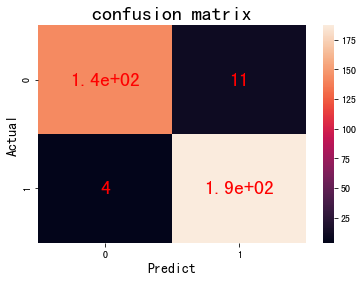

In [42]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

96.2% 准确率的模型

In [10]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.1%

valid_acc:0.9507246376811594
confusion_matrix:[[140  12]
 [  4 188]]
general_index:{'accuracy_score': 0.9534883720930233, 'precision_score': {'precision_score_micro': 0.9534883720930233, 'precision_score_macro': 0.9561111111111111, 'precision_score_weighted': 0.9542377260981911, 'precision_score_None': array([0.97222222, 0.94      ])}, 'recall_score': {'recall_score_micro': 0.9534883720930233, 'recall_score_macro': 0.9501096491228069, 'recall_score_weighted': 0.9534883720930233, 'recall_score_None': array([0.92105263, 0.97916667])}, 'f1_score': {'f1_score_micro': 0.9534883720930233, 'f1_score_macro': 0.9525648097076668, 'f1_score_weighted': 0.9533344450287972, 'f1_score_None': array([0.94594595, 0.95918367])}}
Done!


In [ ]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

# 后面都是自己的测试

### 20221118 测试
对全连接层进行测试

In [15]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 96.2%

0.9623188405797102
Done!


### 20221118 测试
对Longformer + LSTM测试，没跑任务一

In [9]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 95.9%

0.9594202898550724
Done!


### 20221118 测试
在任务一的基础上，对Longformer + LSTM。<br/>
分词模型是Longformer

In [11]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 95.7%

0.9565217391304348
Done!


### 20221118 测试
在任务一的基础上，对Longformer + LSTM。<br/>
分词模型是是任务一

In [ ]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

## 20221214 测试
加入混淆矩阵、精准率、召回率、F1 score等评价指标

In [25]:
valid_acc,y_true,y_pred = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

tensor([1, 0], device='cuda:1')
tensor([[-1.3763,  1.2524],
        [ 3.2752, -2.5231]], device='cuda:1')
tensor([1, 0], device='cuda:1')
tensor([True, True], device='cuda:1')
2.0
Test Accuracy: 0.6%

0.005797101449275362
Done!


print(labels)<br>
print(pred)<br>
print(pred.argmax(1))<br>
print(pred.argmax(1) == labels)<br>
print((pred.argmax(1) == labels).type(torch.float).sum().item())

In [26]:
print(y_true)
print(y_pred)

[[1, 0]]
[[1, 0]]


In [31]:
valid_acc,y_true,y_pred = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 95.7%

0.9565217391304348
Done!


In [32]:
print(y_true)
print(y_pred)

[[0, 1], [1, 0], [0, 1], [1, 0], [0, 0], [0, 1], [1, 1], [0, 0], [0, 1], [1, 1], [1, 0], [0, 0], [0, 1], [0, 0], [0, 1], [1, 0], [1, 1], [1, 0], [0, 1], [1, 0], [0, 0], [1, 1], [1, 0], [0, 1], [1, 0], [0, 0], [0, 0], [0, 1], [0, 0], [1, 0], [1, 1], [0, 1], [0, 1], [0, 1], [0, 0], [0, 0], [1, 0], [0, 1], [0, 0], [0, 1], [0, 1], [0, 1], [1, 1], [1, 0], [1, 1], [1, 1], [1, 1], [0, 0], [0, 0], [0, 1], [1, 1], [1, 1], [1, 0], [0, 1], [1, 1], [1, 1], [1, 0], [1, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 0], [1, 0], [1, 1], [1, 1], [1, 1], [0, 0], [0, 0], [1, 1], [1, 0], [1, 1], [1, 1], [1, 0], [1, 0], [1, 1], [0, 0], [1, 0], [0, 1], [0, 0], [1, 0], [1, 0], [1, 1], [1, 1], [0, 0], [1, 0], [1, 1], [1, 1], [1, 0], [1, 0], [1, 1], [1, 0], [1, 1], [0, 1], [1, 1], [0, 1], [0, 0], [0, 1], [1, 1], [1, 1], [0, 1], [1, 0], [1, 1], [0, 1], [1, 1], [1, 1], [0, 0], [1, 1], [1, 0], [0, 1], [1, 1], [1, 1], [0, 1], [1, 1], [1, 0], [0, 0], [0, 0], [1, 0], [0, 1],

In [38]:
y_true = [i for k in y_true for i in k]
y_pred = [i for k in y_pred for i in k]
print(y_true)
print(y_pred)

[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 

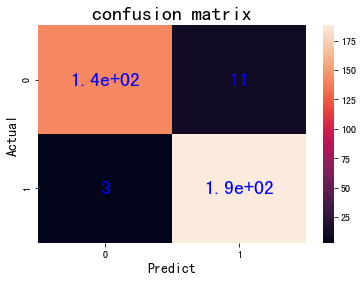

In [39]:
# 混淆矩阵
cm = confusion_matrix(y_true,y_pred,labels=[0,1])
sns.heatmap(cm,annot=True,annot_kws={'size':20,'weight':'bold','color':'blue'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

In [40]:
accuracy_score(y_true,y_pred)

0.9593023255813954

In [41]:
p1 = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
p2 = precision_score(y_true,y_pred,average='macro')
p3 = precision_score(y_true,y_pred,average='weighted')
p4 = precision_score(y_true,y_pred,average=None)

print(p1)
print(p2)
print(p3)
print(p4)

0.9593023255813954
0.9620169814590191
0.9601066680636542
[0.97931034 0.94472362]


In [42]:
r1 = recall_score(y_true,y_pred,average='micro')
r2 = recall_score(y_true,y_pred,average='macro')
r3 = recall_score(y_true,y_pred,average='weighted')
r4 = recall_score(y_true,y_pred,average=None)
print(r1)
print(r2)
print(r3)
print(r4)

0.9593023255813954
0.9561988844403382
0.9593023255813954
[0.92810458 0.98429319]


In [43]:
f1 = f1_score(y_true,y_pred,average='micro')
f2 = f1_score(y_true,y_pred,average='macro')
f3 = f1_score(y_true,y_pred,average='weighted')
f4 = f1_score(y_true,y_pred,average=None)
print(f1)
print(f2)
print(f3)
print(f4)

0.9593023255813954
0.9585613491653759
0.9591734601177397
[0.95302013 0.96410256]


In [47]:
p4.argmax(0)

0

最终测试指标

In [55]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.7%

valid_acc:0.9565217391304348
confusion_matrix:[[142  11]
 [  3 188]]
general_index:{'accuracy_score': 0.9593023255813954, 'precision_score': {'precision_score_micro': 0.9593023255813954, 'precision_score_macro': 0.9620169814590191, 'precision_score_weighted': 0.9601066680636542, 'precision_score_None': array([0.97931034, 0.94472362])}, 'recall_score': {'recall_score_micro': 0.9593023255813954, 'recall_score_macro': 0.9561988844403382, 'recall_score_weighted': 0.9593023255813954, 'recall_score_None': array([0.92810458, 0.98429319])}, 'f1_score': {'f1_score_micro': 0.9593023255813954, 'f1_score_macro': 0.9585613491653759, 'f1_score_weighted': 0.9591734601177397, 'f1_score_None': array([0.95302013, 0.96410256])}}
Done!


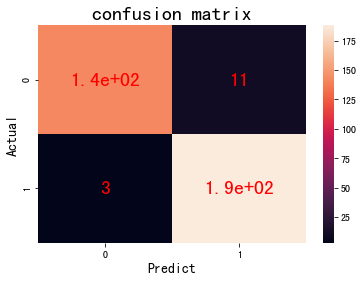

In [61]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

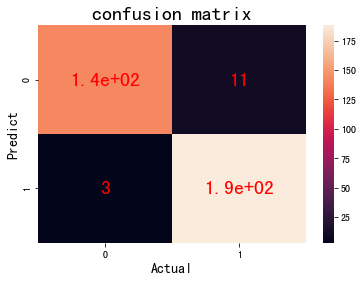

In [62]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Actual',fontsize=14)
plt.ylabel('Predict',fontsize=14)
plt.show()